In [1]:
import sympy as sp
import numpy as np
from sympy.abc import s, z
from control import matlab as m
from utils.units import u, basis

In [2]:
from utils.units.sympy_helpers import without_units

def usubs(var, val, expr):
    return without_units(expr,
        lambda dummify, expr: expr.subs(
            var, dummify(val)))

def var_in(var, unit, expr):
    return usubs(var, var/unit, expr)

In [3]:
gp = 3*(s+200)/(
    (s+9)*(s+2)*(s+1.6)
)

gp = var_in(s, u.rad/u.s, gp)
gp

(600 + 3*second*s/radian)/((1.6 + second*s/radian)*(2 + second*s/radian)*(9 + second*s/radian))

In [4]:
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=-5691439726798981926), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [5]:
from utils.ctrl import expr2sys

gp_tf = expr2sys(nu.to_numeric(gp, as_expr=True), s)

In [6]:
from utils.ctrl import nu_stepinfo

open_loop_info = nu_stepinfo(nu, u.s, 1, m.stepinfo(gp_tf))
dt = open_loop_info["SettlingTime"]/5
dt.n(4)

0.689*second

In [7]:
from sympy import Dict
Dict(open_loop_info)

{Overshoot: 0, Peak: 20.7265201213999, PeakTime: 4.31734704936384*second, RiseTime: 1.91882091082837*second, SettlingMax: 20.7265201213999, SettlingMin: 18.7626227011293, SettlingTime: 3.44515572626003*second, SteadyStateValue: 20.8333333333333, Undershoot: 0}

In [8]:
gp_dtf = m.c2d(gp_tf, nu[dt])
gp_dtf

TransferFunction(array([5.83645919, 4.45814548, 0.09215939]), array([ 1.00000000e+00, -5.86149949e-01,  8.48842703e-02, -1.69646715e-04]), 0.7472743901655688)

In [9]:
from utils.ctrl import siso_numden
from control import TransferFunction
from utils.ratpolys import poly_eval

def deadbeat(num, den):
    return den, [poly_eval(num, 1)] + [-n for n in num]

def deadbeat_sys(sys):
    return TransferFunction(
        *deadbeat(*siso_numden(sys.minreal())),
        sys.dt)

# essentially an S combinator
def with_deadbeat(sys):
    return sys*deadbeat_sys(sys)

In [10]:
gc_dtf = deadbeat_sys(gp_dtf).minreal()
gc_dtf

TransferFunction(array([ 9.62763759e-02, -5.64323928e-02,  8.17234992e-03, -1.63329709e-05]), array([ 1.        , -0.56191314, -0.42921409, -0.00887277]), 0.7472743901655688)

In [11]:
gcl_dtf = m.feedback(gp_dtf*gc_dtf)

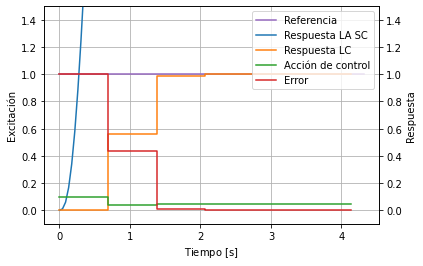

In [12]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

nu_twinx_axes(
    nu, ax_e, ax_r,
    ("Tiempo", u.s),
    ("Excitación", 1),
    ("Respuesta", 1)
)

plot_step(gp_tf, label="Respuesta LA SC")
plot_step(gcl_dtf, label="Respuesta LC")
plot_step(m.feedback(gc_dtf, gp_dtf), label="Acción de control")
plot_step(m.feedback(1, gc_dtf*gp_dtf), label="Error")

plot_ref(label="Referencia")

ax_e.grid()
ax_r.set_ylim(-.1, 1.5)
set_gain_and_legend_loc(gcl_dtf.dcgain(), "upper right")

In [13]:
from utils.ctrlsys import difference_eq

def my_diff_eq(sys):
    e, u = map(sp.Function, "e u".split(" "))
    k = sp.symbols("k", real=True)
    return difference_eq(*siso_numden(sys), e, u, k)

In [14]:
my_diff_eq(gc_dtf).n(4)

Eq(u(k), 0.09628*e(k) - 1.633e-5*e(k - 3) + 0.008172*e(k - 2) - 0.05643*e(k - 1) + 0.008873*u(k - 3) + 0.4292*u(k - 2) + 0.5619*u(k - 1))

In [21]:
from control import TransferFunction
from typing import SupportsFloat

def remove_above_nyquist(
    w,
    sys_or_dt: TransferFunction | SupportsFloat
)-> np.ndarray:
    w = np.asanyarray(w)
    dt = sys_or_dt.dt if (
        isinstance(sys_or_dt, TransferFunction)) else sys_or_dt
    return w[np.where(w<(1/dt)*np.pi)]

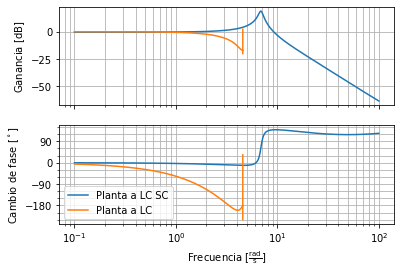

In [22]:
from utils.mpl import nu_sharex_axes
from utils.ctrl import bode_axes
from functools import partial

fig, (ax_gain, ax_phase), add_bode_, add_deg_locator = bode_axes()

add_bode = partial(add_bode_, deg=False, dB=True)

w = np.geomspace(10**-1, 10**2, num=1000)*nu[u.rad/u.s]
w_dtf = remove_above_nyquist(w, gcl_dtf)
add_bode(m.feedback(gp_tf), label="Planta a LC SC", omega=w)
add_bode(gcl_dtf, label="Planta a LC", omega=w_dtf)

add_deg_locator(90)

nu_sharex_axes(nu, ax_phase, ax_gain,
    ("Frecuencia", u.rad/u.s),
    ("Cambio de fase", u.deg),
    ("Ganancia", 1),
    y2_in_db=True)

ax_gain.grid(which='both')
ax_phase.grid(which='both')

ax_phase.legend(); None

/home/fakui/.local/lib/python3.10/site-packages/control/lti.py:199: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")


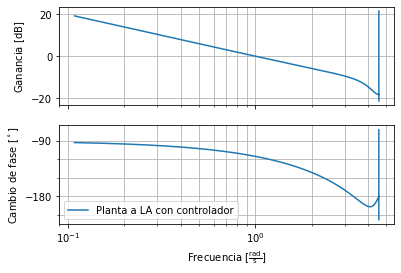

In [16]:
from utils.mpl import nu_sharex_axes
from utils.ctrl import bode_axes
from functools import partial

fig, (ax_gain, ax_phase), add_bode_, add_deg_locator = bode_axes()

add_bode = partial(add_bode_, deg=False, dB=True)

add_bode(gc_dtf*gp_dtf, label="Planta a LA con controlador")

add_deg_locator(90)

nu_sharex_axes(nu, ax_phase, ax_gain,
    ("Frecuencia", u.rad/u.s),
    ("Cambio de fase", u.deg),
    ("Ganancia", 1),
    y2_in_db=True)

ax_gain.grid(which='both')
ax_phase.grid(which='both')

ax_phase.legend(); None